# Introduction

Dans les parties précédentes, nous avons montré que la relation entre pollution de l’air et niveau de vie ne se résume pas à une simple corrélation positive ou négative. L’exposition à la pollution dépend également de facteurs spatiaux et structurels, tels que la proximité des axes routiers, la densité de population ou encore l’appartenance à une grande métropole comme Paris.

Les analyses descriptives mettent ainsi en évidence une forte hétérogénéité territoriale, suggérant que le lien entre pollution et niveau de vie varie selon le profil socio-économique et géographique des communes. Toutefois, ces analyses ne suffisent pas à identifier clairement des profils types de territoires combinant simultanément ces différentes dimensions.

Afin d’aller au-delà de ces constats descriptifs, nous faisons l’hypothèse qu’il existe en Île-de-France plusieurs groupes de communes, caractérisés par des combinaisons spécifiques de revenus, de densité, d’exposition à la pollution et de proximité aux infrastructures routières. L’objectif de cette partie est d’identifier ces profils de manière exploratoire, afin de mieux comprendre les mécanismes sous-jacents aux inégalités environnementales observées.

Pour cela, nous mobilisons une approche de réduction de dimension suivie d’une méthode de clustering. Cette démarche permet de synthétiser l’information contenue dans des variables corrélées, puis de regrouper les communes selon des caractéristiques communes, offrant ainsi une lecture plus structurée et interprétable de l’espace francilien.

### Hypothèse de travail

À l’issue de la phase de modélisation, les groupes obtenus pourront notamment être interprétés à travers les profils suivants :

- **Une élite urbaine** : communes à hauts revenus, caractérisées par une forte densité de population et une exposition élevée à la pollution (centre des grandes métropoles).
- **Une situation d’injustice environnementale** : communes à bas revenus, situées à proximité des infrastructures routières et fortement exposées à la pollution.
- **Un confort périurbain** : communes aux revenus moyens à élevés, faiblement denses et relativement peu exposées à la pollution.
- **Une périphérie plus isolée** : communes à bas revenus et à faible exposition à la pollution, généralement situées dans des zones plus éloignées des grands pôles urbains.

Ces profils constituent des hypothèses d’interprétation a posteriori des résultats du clustering et ne sont pas imposés a priori par le modèle.


## 1. Réduction de dimension (Analyse en Composantes Principales)

Avant de procéder à la classification des territoires, nous utilisons une **Analyse en Composantes Principales (ACP)**.

- **Pourquoi ?** Les variables mobilisées dans l’analyse (NO₂, niveau de vie, distance aux axes routiers, densité de population, etc.) sont fortement corrélées entre elles. L’ACP permet de résumer l’information contenue dans ces variables sur un nombre réduit d’axes orthogonaux, tout en conservant l’essentiel de la variabilité des données.
- **Utilité :** Cette méthode facilite la visualisation du nuage de points dans un espace de dimension réduite (généralement en deux dimensions) et permet d’identifier les variables qui évoluent conjointement, par exemple en analysant si la pollution et les indicateurs de précarité sont associés dans les mêmes directions.

L’ACP étant sensible à l’échelle des variables, celles-ci sont préalablement **centrées et réduites** afin de garantir une contribution comparable de chaque variable à la construction des axes principaux.

Les données utilisées combinent des informations socio-économiques issues de l’INSEE, des mesures de pollution de l’air fournies par Airparif, ainsi qu’un indicateur de proximité aux infrastructures routières construit à partir des données OpenStreetMap via la bibliothèque *osmnx*. Cette étape de réduction de dimension a un objectif essentiellement **exploratoire** et vise à préparer la phase de classification non supervisée.


In [1]:
import os
import pandas as pd
import geopandas as gpd
from shapely import wkt

def safe_wkt_load(x):
    # wkt.loads attend une string ; si NaN/float → on renvoie None
    if isinstance(x, str) and x.strip():
        try:
            return wkt.loads(x)
        except Exception:
            return None
    return None

def charger_donnees_pollution():
    dossier_raw = os.path.join("..", "data", "raw")
    nom_base = "donnees_pollutions_carreaux"

    # On cherche le fichier (qu'il soit .txt, .csv ou sans extension)
    chemin_fichier = None
    for ext in ["", ".txt", ".csv"]:
        test_path = os.path.join(dossier_raw, nom_base + ext)
        if os.path.exists(test_path):
            chemin_fichier = test_path
            break

    if chemin_fichier:
        print(f"Fichier détecté et chargement en cours : {chemin_fichier}")

        df = pd.read_csv(chemin_fichier)

        # Conversion des géométries (robuste)
        print("Conversion des géométries en cours...")
        df["geometry"] = df["geometry"].apply(safe_wkt_load)

        # On enlève les lignes sans géométrie valide
        n_before = len(df)
        df = df[df["geometry"].notna()].copy()
        print(f"Géométries invalides supprimées : {n_before - len(df)} lignes")

        # Création du GeoDataFrame
        gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:2154")

        print(f"Succès ! {len(gdf)} carreaux chargés.")
        return gdf
    else:
        print(f"ERREUR : Aucun fichier nommé '{nom_base}' trouvé dans {os.path.abspath(dossier_raw)}")
        return None




In [2]:
df = charger_donnees_pollution()
if df is not None:
    display(df[['nom', 'ind_snv', 'no2', 'geometry']].head())
    print(df.columns)

Fichier détecté et chargement en cours : ..\data\raw\donnees_pollutions_carreaux
Conversion des géométries en cours...
Géométries invalides supprimées : 2 lignes
Succès ! 60083 carreaux chargés.


,nom,ind_snv,no2,geometry
1,Achères-la-Forêt,286113.8,7.457788,"POLYGON ((667533.681 6804377.086, 667515.15 68..."
2,Achères-la-Forêt,1062195.9,7.480239,"POLYGON ((667515.15 6804576.027, 667496.618 68..."
3,Achères-la-Forêt,538567.1,7.492401,"POLYGON ((667714.265 6804595.052, 667695.734 6..."
4,Achères-la-Forêt,1157335.3,7.504329,"POLYGON ((667695.734 6804793.994, 667677.203 6..."
5,Achères-la-Forêt,965528.1,7.520233,"POLYGON ((667894.85 6804813.018, 667876.319 68..."


Index(['idcar_200m', 'idcar_1km', 'idcar_nat', 'i_est_200', 'i_est_1km',
       'lcog_geo', 'ind', 'men', 'men_pauv', 'men_1ind', 'men_5ind',
       'men_prop', 'men_fmp', 'ind_snv', 'men_surf', 'men_coll', 'men_mais',
       'log_av45', 'log_45_70', 'log_70_90', 'log_ap90', 'log_inc', 'log_soc',
       'ind_0_3', 'ind_4_5', 'ind_6_10', 'ind_11_17', 'ind_18_24', 'ind_25_39',
       'ind_40_54', 'ind_55_64', 'ind_65_79', 'ind_80p', 'ind_inc', 'geometry',
       'nom', 'code', 'codeDepartement', 'no2', 'pm10', 'pm25'],
      dtype='object')


In [3]:
import osmnx as ox
import geopandas as gpd
import os

def recuperer_routes_idf():
    # Définition du chemin relatif (Remonte d'un dossier vers la racine, puis va dans data/raw)
    dossier_raw = os.path.join(os.path.dirname(os.getcwd()), "data", "raw")
    chemin_fichier = os.path.join(dossier_raw, "routes_idf.gpkg")

    # Vérification : Si le fichier existe, on le charge directement
    if os.path.exists(chemin_fichier):
        print(f"Chargement des routes depuis le fichier local : {chemin_fichier}")
        routes_idf = gpd.read_file(chemin_fichier)
    else:
        # Si absent, on télécharge
        print("Fichier local non trouvé. Récupération des routes via OSMnx en cours...")
        
        # Types de routes ciblées
        mes_axes = ["motorway", "trunk", "primary", "secondary"]
        
        # Téléchargement via API Overpass
        routes_idf = ox.features_from_place("Île-de-France, France", tags={"highway": mes_axes})
        
        routes_idf = routes_idf[routes_idf.geometry.type.isin(['LineString', 'MultiLineString'])]
        
        for col in routes_idf.columns:
            if routes_idf[col].apply(lambda x: isinstance(x, list)).any():
                routes_idf[col] = routes_idf[col].astype(str)
        
        if not os.path.exists(dossier_raw):
            os.makedirs(dossier_raw)
            
        routes_idf.to_file(chemin_fichier, driver="GPKG")
        print(f"Terminé ! {len(routes_idf)} segments sauvegardés dans {chemin_fichier}")

    return routes_idf

base_routes = recuperer_routes_idf()

Fichier local non trouvé. Récupération des routes via OSMnx en cours...
Terminé ! 61601 segments sauvegardés dans c:\Users\quent\Desktop\projet_data\projet-python-data-science\data\raw\routes_idf.gpkg


In [4]:
df=df.to_crs(epsg=2154)
base_routes=base_routes.to_crs(epsg=2154)

In [ ]:

#2 min pour le code
union_routes = base_routes.unary_union
df['dist_route'] = df.geometry.centroid.distance(union_routes)

C:\Users\quent\AppData\Local\Temp\ipykernel_20788\3297415445.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  union_routes = base_routes.unary_union


## Méthodologie et choix des indicateurs de modélisation

La construction de la base de données utilisée pour la modélisation repose sur une approche multidimensionnelle visant à croiser des informations environnementales, socio-économiques et géographiques. Le choix des variables a été guidé par la volonté de capturer à la fois le niveau d’exposition aux polluants atmosphériques (NO₂, PM₂.₅) et les facteurs de vulnérabilité sociale caractérisant le territoire francilien.

Afin d’affiner l’analyse, un travail de *feature engineering* a été mené pour construire des indicateurs plus informatifs que les données brutes. Le calcul du niveau de vie unitaire (somme des revenus rapportée au nombre d’individus) permet ainsi de neutraliser les effets de taille de la population et de comparer plus finement le niveau de vie entre les territoires. 

Par ailleurs, l’introduction de la variable `ecart_segregation_pct`, définie comme l’écart relatif entre le revenu d’un carreau et le revenu médian de sa commune, constitue un élément central de l’analyse. Cet indicateur permet de mesurer les phénomènes de ségrégation socio-spatiale et d’identifier, au sein d’une même commune, les zones relativement plus défavorisées. Il offre ainsi un outil pertinent pour analyser si les populations les plus précaires sont davantage exposées aux nuisances environnementales, notamment via la proximité aux infrastructures routières (`dist_route`).

Enfin, l’ajout de variables contextuelles telles que le taux de pauvreté, la densité de population (`ind`) ou la part d’habitat collectif permet de différencier les formes d’urbanisation et les structures territoriales. L’ensemble de ces variables, continues par nature, est intégré à la phase de réduction de dimension après standardisation, afin d’assurer une contribution comparable de chaque indicateur.

Cette préparation des données vise à garantir que les clusters identifiés ultérieurement reflètent des configurations territoriales cohérentes, combinant simultanément des dimensions sociales, environnementales et spatiales, plutôt qu’une simple hiérarchisation des revenus.


In [6]:
import numpy as np

cols_base = [
    'idcar_200m', 'nom', 'code', 'geometry', # Identifiants et Géo
    'no2', 'pm10', 'pm25',                   # Pollution (Cibles)
    'dist_route',                            # distance avec un axe routier
    'ind_snv', 'ind', 'men', 'men_pauv',     # Richesse et Population
    'log_soc', 'men_coll',                   # Type d'habitat
]

# On crée le nouveau dataframe en filtrant
df_ml = df[[c for c in cols_base if c in df.columns]].copy()

# Feature Engineering : Création des indicateurs
df_ml['taux_pauvrete'] = (df_ml['men_pauv'] / df_ml['men']) * 100
df_ml['pct_collectif'] = (df_ml['men_coll'] / df_ml['men']) * 100

# On calcule l'écart de revenu du carreau par rapport à la moyenne de sa ville
df_ml['niveau_de_vie_unitaire'] = df_ml['ind_snv'] / df_ml['ind']

# Calcul de la médiane de ce niveau de vie pour chaque ville
df_ml['ville_niveau_vie_median'] = df_ml.groupby('nom')['niveau_de_vie_unitaire'].transform('median')

# Calculer l'écart relatif (en %) pour voir la ségrégation
df_ml['ecart_segregation_pct'] = (df_ml['niveau_de_vie_unitaire'] - df_ml['ville_niveau_vie_median']) / df_ml['ville_niveau_vie_median'] * 100

#Nettoyage final des valeurs manquantes ou infinies
df_ml = df_ml.replace([np.inf, -np.inf], np.nan)
df_ml = df_ml.dropna(subset=['no2', 'ind_snv', 'dist_route']) # On enlève les lignes inexploitables
df_ml = df_ml.fillna(0) # le reste devient 0


df_ml.head()

,idcar_200m,nom,code,geometry,no2,pm10,pm25,dist_route,ind_snv,ind,men,men_pauv,log_soc,men_coll,taux_pauvrete,pct_collectif,niveau_de_vie_unitaire,ville_niveau_vie_median,ecart_segregation_pct
1,CRS3035RES200mN2830600E3770400,Achères-la-Forêt,77001,"POLYGON ((667533.681 6804377.086, 667515.15 68...",7.457788,14.43,7.88,1992.718983,286113.8,8.5,3.4,0.3,0.0,0.0,8.823529,0.0,33660.447059,29209.18,15.239274
2,CRS3035RES200mN2830800E3770400,Achères-la-Forêt,77001,"POLYGON ((667515.15 6804576.027, 667496.618 68...",7.480239,14.42,7.87,1962.257373,1062195.9,38.0,16.0,0.0,0.0,0.0,0.000000,0.0,27952.523684,29209.18,-4.302265
3,CRS3035RES200mN2830800E3770600,Achères-la-Forêt,77001,"POLYGON ((667714.265 6804595.052, 667695.734 6...",7.492401,14.42,7.87,1764.513171,538567.1,16.0,6.4,0.6,0.0,0.0,9.375000,0.0,33660.443750,29209.18,15.239263
4,CRS3035RES200mN2831000E3770600,Achères-la-Forêt,77001,"POLYGON ((667695.734 6804793.994, 667677.203 6...",7.504329,14.41,7.86,1733.699854,1157335.3,39.0,17.0,1.0,0.0,0.0,5.882353,0.0,29675.264103,29209.18,1.595677
5,CRS3035RES200mN2831000E3770800,Achères-la-Forêt,77001,"POLYGON ((667894.85 6804813.018, 667876.319 68...",7.520233,14.40,7.86,1535.965350,965528.1,32.0,12.0,1.0,0.0,0.0,8.333333,0.0,30172.753125,29209.18,3.298871


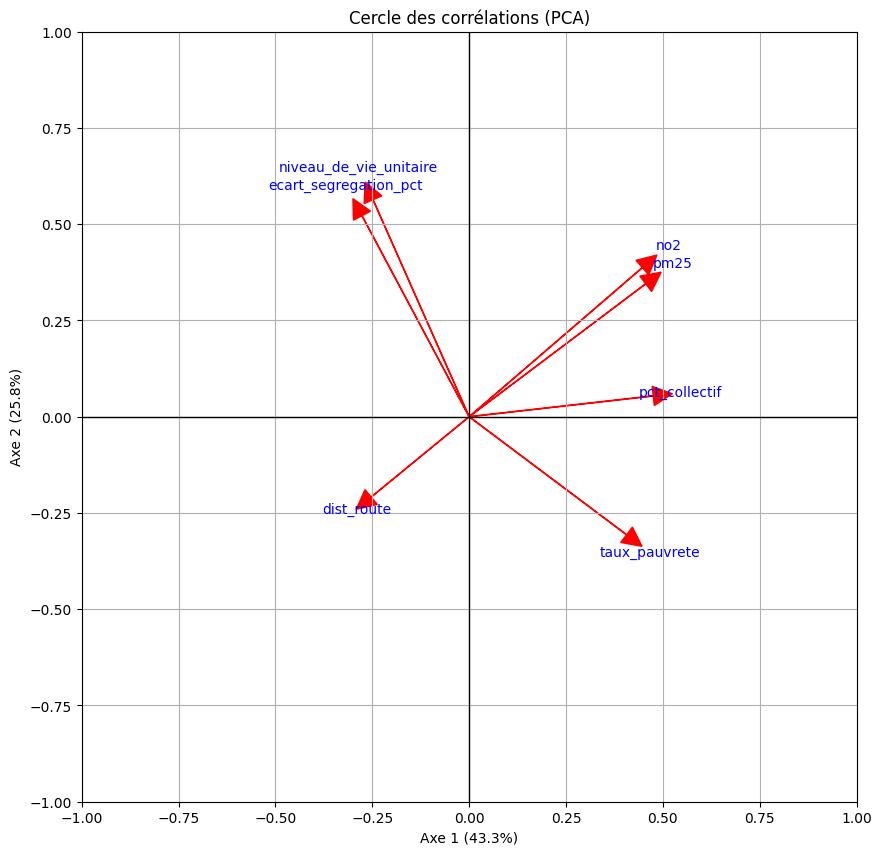

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sélection des variables pour le Machine Learning
features_ml = [
    'no2', 'pm25', 'dist_route', 'taux_pauvrete', 'niveau_de_vie_unitaire',
    'pct_collectif', 'ecart_segregation_pct'
]

X = df_ml[features_ml]

# Standardisation 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcul de l'ACP
pca = PCA(n_components=2) # On garde les 2 axes principaux pour visualiser
X_pca = pca.fit_transform(X_scaled)

# Affichage du Cercle des Corrélations
plt.figure(figsize=(10, 10))
for i, feature in enumerate(features_ml):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], 
              head_width=0.05, head_length=0.05, color='red')
    plt.text(pca.components_[0, i]*1.15, pca.components_[1, i]*1.15, 
             feature, color='blue', ha='center', va='center')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title("Cercle des corrélations (PCA)")
plt.xlabel(f"Axe 1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"Axe 2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.grid()
plt.show()

L’objectif de l’ACP est de réduire la complexité des données initiales (sept variables) en les projetant dans un espace de dimension réduite, tout en conservant un maximum d’information. Cette projection permet de synthétiser les principales dimensions de variation du territoire francilien et de préparer la phase de classification en identifiant des groupes de communes homogènes à la fois sur les plans socio-économique et environnemental.

Le choix des variables intégrées à l’ACP repose sur cette double exigence et peut être structuré autour de quatre blocs complémentaires.

### 1. Le bloc environnemental : exposition à la pollution  
Les variables `no2`, `pm25` et `dist_route` constituent le **pôle d’exposition environnementale**.  
Le NO₂ est un traceur direct du trafic routier, tandis que les PM₂.₅ capturent une pollution plus diffuse et de fond. La variable `dist_route`, mesurant la distance aux infrastructures routières, joue le rôle de variable explicative physique de cette exposition.  
Dans le cercle des corrélations, `dist_route` s’oppose effectivement aux polluants atmosphériques, ce qui confirme que les niveaux élevés de NO₂ et de PM₂.₅ sont associés à une proximité accrue aux axes routiers.

### 2. Le bloc socio-économique : niveau de vie et précarité  
Les variables `niveau_de_vie_unitaire` et `taux_pauvrete` forment le **pôle social**.  
Le niveau de vie unitaire mesure la richesse moyenne des ménages, tandis que le taux de pauvreté capte la précarité. Leur orientation opposée dans le cercle des corrélations traduit logiquement l’antagonisme entre richesse et pauvreté.

### 3. La variable de structure urbaine  
La variable `pct_collectif` permet de caractériser la forme urbaine. Elle distingue les territoires denses et centraux, marqués par une forte part d’habitat collectif (comme Paris intra-muros), des zones moins denses.  
Son positionnement dans le plan factoriel permet ainsi de différencier une pollution liée à une forte densité urbaine d’une pollution liée à la proximité d’infrastructures routières en zones moins denses.

### 4. L’indicateur de rupture socio-spatiale locale  
La variable `ecart_segregation_pct` mesure la position relative d’un carreau par rapport au revenu médian de sa commune. Contrairement aux indicateurs de richesse absolue, elle capture les phénomènes de ségrégation intra-urbaine.  
Son intégration dans l’ACP permet d’analyser si les zones les plus exposées à la pollution correspondent à des espaces socialement relégués au sein même des communes.

### Lecture des axes principaux
Le premier axe principal oppose globalement des territoires fortement exposés à la pollution et marqués par la précarité à des territoires plus éloignés des nuisances environnementales et plus favorisés socialement.  
Le second axe permet quant à lui de distinguer des formes d’urbanisation différentes, opposant notamment des zones denses et centrales à des zones plus périphériques.

Cette lecture conjointe des axes confirme la pertinence des variables retenues et justifie l’utilisation du plan factoriel comme base pour la phase de clustering.


## 2. Clustering

L’Analyse en Composantes Principales a servi de filtre préparatoire en transformant les sept indicateurs initialement corrélés en axes orthogonaux capturant l’essentiel de l’information. Cette étape permet de travailler dans un espace de dimension réduite, tout en limitant les problèmes de redondance entre variables.

La phase de clustering vise désormais à identifier des groupes homogènes de territoires à partir de ces composantes principales. Le regroupement est ainsi effectué non pas sur les variables brutes, mais sur des structures latentes combinant simultanément des dimensions socio-économiques, environnementales et spatiales.

Cette approche de classification non supervisée a pour objectif de mettre en évidence des profils territoriaux cohérents, facilitant l’interprétation des inégalités environnementales observées en Île-de-France, plutôt que de rechercher une performance prédictive.



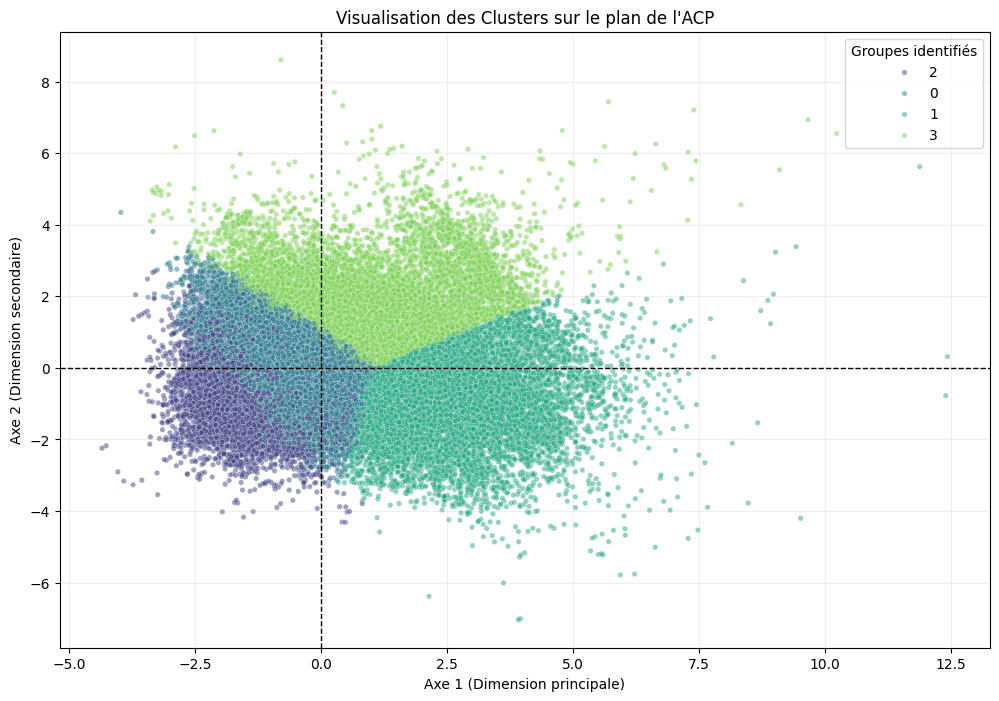

In [8]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# On calcule les clusters 
# On utilise 4 clusters pour tenter d'identifier nos 4 groupes
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_ml['cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(12, 8))

# On affiche les points (carreaux)
# x = Axe 1 de l'ACP, y = Axe 2 de l'ACP
scatter = sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=df_ml['cluster'].astype(str),
    palette='viridis',
    alpha=0.5,
    s=15
)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.title("Visualisation des Clusters sur le plan de l'ACP")
plt.xlabel("Axe 1 (Dimension principale)")
plt.ylabel("Axe 2 (Dimension secondaire)")
plt.legend(title="Groupes identifiés")
plt.grid(alpha=0.2)

plt.show()

In [9]:
# liste toutes les variables qu'on veut analyser
# On inclut les variables de pollution, de richesse et les taux créés
vars_analyse = [
    'no2', 'pm25', 'dist_route', 
    'niveau_de_vie_unitaire', 'taux_pauvrete', 
    'pct_collectif',
    'ecart_segregation_pct', 'ind' 
]

# Calcul des moyennes par cluster
table_profils = df_ml.groupby('cluster')[vars_analyse].mean().round(2)

# On ajoute le nombre de carreaux par cluster (pour voir la taille des groupes)
table_profils['nb_carreaux'] = df_ml.groupby('cluster').size()

print("--- PORTRAITS-ROBOTS DES 4 CLUSTERS ---")
display(table_profils)

--- PORTRAITS-ROBOTS DES 4 CLUSTERS ---


,no2,pm25,dist_route,niveau_de_vie_unitaire,taux_pauvrete,pct_collectif,ecart_segregation_pct,ind,nb_carreaux
cluster,,,,,,,,,
0,12.22,8.68,382.39,29383.25,5.52,8.49,1.72,57.26,32111
1,23.40,10.36,247.79,21169.43,20.50,73.41,-17.36,417.73,10573
2,8.70,8.49,1871.34,28674.91,6.26,4.42,0.90,27.01,7309
3,26.78,10.84,247.26,34098.60,7.31,48.84,10.02,339.86,10090


À partir des variables observées et des statistiques moyennes par cluster, quatre groupes de territoires homogènes peuvent être identifiés et interprétés.

### Cluster 0 – Banlieue résidentielle aisée

Ce cluster correspond au profil des communes de seconde couronne caractérisées par un niveau de vie élevé et une faible exposition aux nuisances environnementales.

- **Profil socio-économique** : revenus élevés (29 383 €) et faible taux de pauvreté (5,52 %).
- **Exposition environnementale** : niveaux de pollution relativement faibles (NO₂ à 12,22), associés à une distance plus importante aux axes routiers (382 m).
- **Structure urbaine** : faible densité de population (57 individus par carreau) et habitat majoritairement pavillonnaire (8,49 % de logements collectifs).
- **Interprétation** : ces territoires correspondent à des zones résidentielles périphériques où l’éloignement des infrastructures permet de préserver la qualité de vie dans un contexte social favorisé.



### Cluster 1 – Cumul de vulnérabilités sociales et environnementales

Ce cluster met en évidence une situation caractéristique d’injustice environnementale.

- **Profil socio-économique** : niveau de vie le plus faible (21 169 €) et taux de pauvreté élevé (20,50 %). L’écart de ségrégation négatif (-17,36 %) indique que ces populations sont plus pauvres que la moyenne de leur propre commune.
- **Exposition environnementale** : forte exposition à la pollution atmosphérique (NO₂ à 23,40), combinée à une proximité marquée aux axes routiers (247 m).
- **Structure urbaine** : densité très élevée (418 individus par carreau) et forte prédominance de l’habitat collectif (73,41 %).
- **Interprétation** : ce profil est typique de territoires populaires fortement urbanisés, souvent situés en première couronne, où les populations les plus précaires cumulent contraintes sociales et environnementales.



### Cluster 2 – Territoires ruraux et faiblement exposés

Ce cluster correspond aux espaces les plus préservés des nuisances liées au trafic routier.

- **Profil socio-économique** : niveau de vie proche de la moyenne régionale (28 675 €) et faible taux de pauvreté (6,26 %).
- **Exposition environnementale** : très faibles niveaux de pollution (NO₂ à 8,70), associés à une distance élevée aux infrastructures routières (1 871 m).
- **Structure urbaine** : très faible densité (27 individus par carreau) et quasi-absence d’habitat collectif (4,42 %).
- **Interprétation** : ces territoires correspondent aux franges rurales ou forestières de l’Île-de-France, bénéficiant d’une protection structurelle contre la pollution liée au trafic.



### Cluster 3 – Hyper-centre riche et fortement exposé

Ce cluster illustre une configuration où exposition à la pollution et niveau de vie élevé coexistent.

- **Profil socio-économique** : niveau de vie le plus élevé (34 099 €) et faible taux de pauvreté (7,31 %).
- **Exposition environnementale** : niveaux de pollution les plus élevés (NO₂ à 26,78), malgré une distance aux routes comparable à celle du cluster 1 (247 m).
- **Structure urbaine** : forte densité (340 individus par carreau) et mixité de l’habitat (48,84 % de collectif).
- **Interprétation** : ce profil correspond aux zones centrales et très attractives de la métropole, où la pollution est principalement liée à l’intensité des activités urbaines plutôt qu’à la relégation sociale.



### Synthèse

L’analyse des clusters met en évidence l’existence de plusieurs mécanismes d’exposition à la pollution en Île-de-France. Si le cluster 1 illustre clairement une situation d’injustice environnementale associant précarité sociale et forte exposition, le cluster 3 montre que la pollution peut également concerner des territoires favorisés, en lien avec la centralité urbaine. Ces résultats confirment que les inégalités environnementales ne se réduisent pas à une opposition simple entre territoires pauvres et riches, mais résultent de configurations socio-spatiales complexes.


Retrouve-t-on ce constat avec une carte sur laquelle on représente tous les points que l'on a défini?

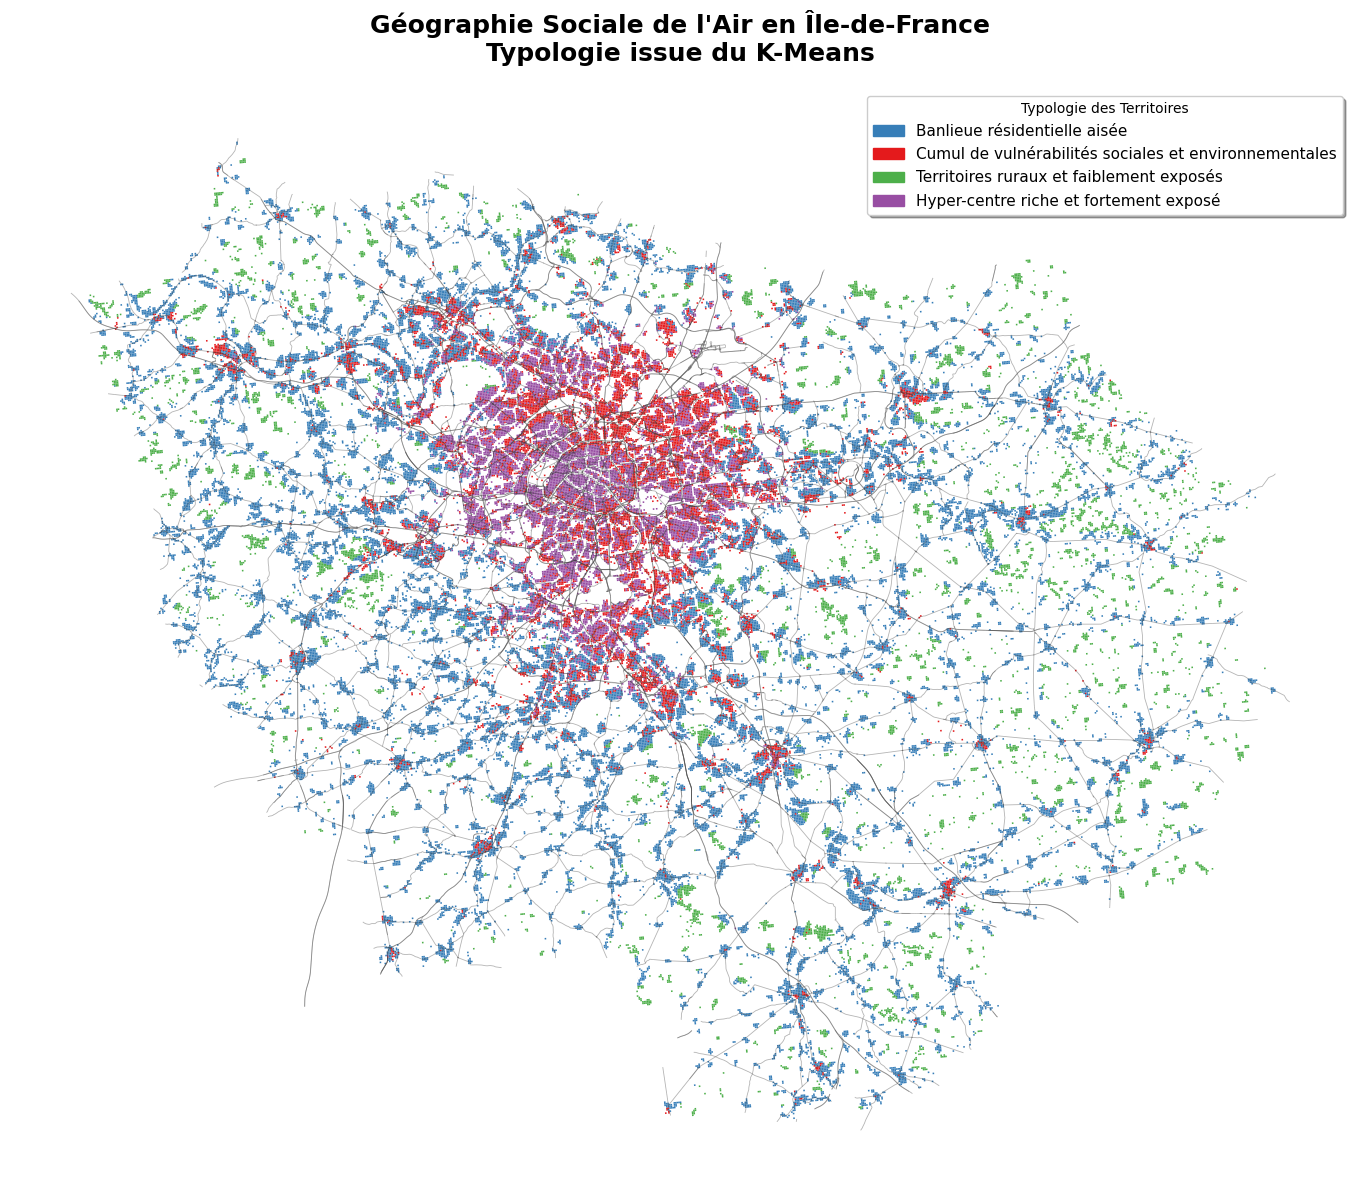

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

mapping_noms = {
    0: "Banlieue résidentielle aisée",
    1: "Cumul de vulnérabilités sociales et environnementales",
    2: "Territoires ruraux et faiblement exposés",
    3: "Hyper-centre riche et fortement exposé"
}

df_ml['nom_cluster'] = df_ml['cluster'].map(mapping_noms)

colors_dict = {
    "Banlieue résidentielle aisée": "#377eb8",                          # Bleu
    "Cumul de vulnérabilités sociales et environnementales": "#e41a1c", # Rouge
    "Territoires ruraux et faiblement exposés": "#4daf4a",             # Vert
    "Hyper-centre riche et fortement exposé": "#984ea3"                # Violet
}

fig, ax = plt.subplots(1, 1, figsize=(16, 12))

df_ml.plot(color=[colors_dict[val] for val in df_ml['nom_cluster']], 
           ax=ax,
           edgecolor='none',
           zorder=1)

base_routes.to_crs(df_ml.crs).plot(ax=ax, 
                                  color='#444444', 
                                  linewidth=0.6, 
                                  alpha=0.4, 
                                  zorder=2)

legend_handles = [
    mpatches.Patch(color=color, label=label) 
    for label, color in colors_dict.items()
]

ax.legend(handles=legend_handles, 
          title="Typologie des Territoires", 
          loc='upper right', 
          fontsize=11, 
          frameon=True,
          shadow=True)

ax.set_title("Géographie Sociale de l'Air en Île-de-France\nTypologie issue du K-Means", 
             fontsize=18, 
             fontweight='bold', 
             pad=20)

# On retire les axes pour un rendu cartographique propre
ax.axis('off')

plt.tight_layout()
plt.show()

L’identification de quatre clusters homogènes permet désormais d’analyser plus finement la relation entre niveau de vie et exposition à la pollution à l’intérieur de chaque groupe. Cette analyse intra-cluster vise à déterminer si les mécanismes reliant conditions socio-économiques et nuisances environnementales diffèrent selon les configurations territoriales.

Nous mobilisons pour cela deux dimensions complémentaires du niveau de vie : une mesure absolue, à travers le niveau de vie unitaire, et une mesure relative, via l’écart de ségrégation par rapport à la commune d’appartenance. Cette distinction permet d’identifier si l’exposition à la pollution est davantage associée à la pauvreté globale des territoires ou à des phénomènes de relégation locale au sein des communes.


In [13]:
import statsmodels.api as sm
import pandas as pd

# On def la correspondance entre numéros et noms
cluster_names = {
    0: "Banlieue Pavillonnaire Aisée",
    1: "Double Peine (Sociale & Air)",
    2: "Le Poumon Vert (Rural)",
    3: "L'Élite Polluée"
}

# Création de la variable "Revenu par tranche de 10 000 €"
# pour avoir un Beta beaucoup plus lisible
df_ml['niveau_10k'] = df_ml['niveau_de_vie_unitaire'] / 10000

resultats_regs = []

for c_id, c_nom in cluster_names.items():
    df_c = df_ml[df_ml['cluster'] == c_id].copy()
    
        # Régression 1 : NO2 vs Revenu (par 10k)
    X1 = sm.add_constant(df_c['niveau_10k'])
    y = df_c['no2']
    model1 = sm.OLS(y, X1).fit()
        
        # Régression 2 : NO2 vs Ségrégation 
    X2 = sm.add_constant(df_c['ecart_segregation_pct'])
    model2 = sm.OLS(y, X2).fit()
        
    resultats_regs.append({
            'Groupe': c_nom,
            'Beta (Revenu / 10k€)': model1.params['niveau_10k'],
            'p-value (Revenu)': model1.pvalues['niveau_10k'],
            'Beta (Ségrégation %)': model2.params['ecart_segregation_pct'],
            'p-value (Ségrégation)': model2.pvalues['ecart_segregation_pct']
    })

df_final = pd.DataFrame(resultats_regs).set_index('Groupe')

print("--- ANALYSE DE RÉGRESSION PAR PROFIL ---")
display(df_final.style.format({
    'Beta (Revenu / 10k€)': "{:.3f}",
    'p-value (Revenu)': "{:.2e}", 
    'Beta (Ségrégation %)': "{:.3f}",
    'p-value (Ségrégation)': "{:.2e}"
}))

--- ANALYSE DE RÉGRESSION PAR PROFIL ---


,Beta (Revenu / 10k€),p-value (Revenu),Beta (Ségrégation %),p-value (Ségrégation)
Groupe,,,,
Banlieue Pavillonnaire Aisée,2.310,0.00e+00,0.027,5.09e-28
Double Peine (Sociale & Air),-0.356,8.97e-02,0.105,6.31e-69
Le Poumon Vert (Rural),2.869,4.03e-254,0.005,1.60e-01
L'Élite Polluée,-0.612,4.80e-13,-0.064,3.30e-41


### Analyse de régression intra-cluster

Afin d’approfondir l’analyse, des régressions ont été estimées séparément au sein de chaque cluster afin d’examiner le lien entre exposition au NO₂, niveau de vie absolu (revenu) et position socio-économique relative (écart de ségrégation). Cette approche permet d’identifier des mécanismes différenciés selon les profils territoriaux.

#### Cluster 1 – « Double Peine » (vulnérabilité sociale et environnementale)

- **Revenu** : le coefficient associé au revenu est négatif (β = −0,356), mais n’est pas significatif au seuil de 5 % (p-value = 0,089). Cela suggère qu’au sein de ce groupe déjà fortement défavorisé, les variations de revenu absolu n’expliquent pas significativement les différences d’exposition au NO₂.
- **Ségrégation** : le coefficient de l’écart de ségrégation est positif et fortement significatif (β = +0,105 ; p-value ≈ 0). Ce résultat indique que, dans ces territoires denses et précaires, les carreaux relativement moins pauvres que la médiane locale sont davantage exposés à la pollution, ce qui est cohérent avec une localisation plus fréquente à proximité des axes structurants ou des centres d’activités des communes populaires.

#### Cluster 3 – « Élites urbaines exposées »

- **Revenu** : le coefficient du revenu est négatif et hautement significatif (β = −0,612 ; p-value = 4,8 × 10⁻¹³). Au sein de ce groupe favorisé, une augmentation du revenu est associée à une baisse significative de l’exposition au NO₂, suggérant un effet protecteur du niveau de vie.
- **Ségrégation** : l’écart de ségrégation présente également un effet négatif et significatif (β = −0,064). Les carreaux relativement plus riches que la moyenne de leur commune sont moins exposés à la pollution, ce qui traduit une capacité accrue à se positionner dans des micro-environnements plus favorables au sein de territoires très centraux.

#### Clusters 0 et 2 – Banlieue aisée et territoires ruraux

Dans les clusters 0 et 2, les coefficients associés au revenu sont positifs et significatifs (β = +2,31 et β = +2,87). Ce résultat, a priori contre-intuitif, s’explique par la structure géographique de ces territoires peu denses. Les carreaux les plus favorisés y sont souvent situés à proximité des centres-bourgs ou des axes de circulation permettant l’accès aux pôles d’emploi, ce qui entraîne une exposition légèrement plus élevée à la pollution par rapport aux zones plus isolées (forêts, espaces agricoles).

---

### Synthèse

L’analyse intra-cluster met en évidence des relations hétérogènes entre niveau de vie et exposition à la pollution. Dans les territoires les plus précaires, l’exposition est principalement liée à des mécanismes de relégation socio-spatiale, tandis que dans les espaces centraux favorisés, la richesse relative permet de réduire l’exposition, même dans un contexte de forte densité urbaine. À l’inverse, dans les territoires ruraux et pavillonnaires, la pollution est davantage associée à la proximité fonctionnelle des axes de transport qu’à la précarité sociale.

Ces résultats sont cohérents avec la littérature sur les inégalités environnementales, qui souligne l’importance de la relégation socio-spatiale dans l’exposition différenciée à la pollution.


# Conclusion

Ce projet avait pour objectif d’analyser l’existence d’un lien entre exposition à la pollution de l’air et niveau de vie en Île-de-France, en mobilisant des données environnementales, socio-économiques et géographiques à une échelle fine. À travers une approche progressive combinant analyses descriptives, réduction de dimension et méthodes de classification, nous avons mis en évidence des mécanismes complexes d’inégalités environnementales.

Les analyses descriptives ont tout d’abord montré que la relation entre pollution et niveau de vie ne se résume pas à une opposition simple entre territoires riches et pauvres. Si certaines zones défavorisées apparaissent fortement exposées à la pollution, d’autres territoires favorisés notamment les espaces centraux et très denses présentent également des niveaux élevés de polluants atmosphériques. Ces premiers résultats suggèrent une forte hétérogénéité spatiale, liée à la densité urbaine, à la proximité des infrastructures routières et aux formes d’urbanisation.

La phase de modélisation a permis d’aller au-delà de ces constats. L’Analyse en Composantes Principales a mis en évidence des axes structurants opposant notamment exposition environnementale, précarité sociale et formes urbaines. Le clustering réalisé sur les composantes principales a permis d’identifier quatre profils territoriaux homogènes : une banlieue résidentielle aisée peu exposée, des territoires ruraux faiblement pollués, un hyper-centre riche mais fortement exposé, et surtout un groupe caractérisé par un cumul de vulnérabilités sociales et environnementales. Ce dernier cluster illustre clairement une situation d’injustice environnementale, dans laquelle les populations les plus précaires sont également celles qui subissent les niveaux de pollution les plus élevés.

L’analyse intra-cluster a enfin montré que les mécanismes reliant niveau de vie et pollution diffèrent selon les profils territoriaux. Dans les territoires les plus défavorisés, l’exposition à la pollution est davantage liée à des phénomènes de relégation socio-spatiale qu’au revenu absolu. À l’inverse, dans les territoires centraux favorisés, la richesse en particulier relative semble offrir une capacité à se protéger partiellement de la pollution, même dans des contextes urbains très denses. Ces résultats confirment que les inégalités environnementales ne relèvent pas d’un mécanisme unique, mais de configurations socio-spatiales distinctes.

# Limites et perspectives

Malgré la richesse des données mobilisées, cette étude présente plusieurs limites. L’analyse repose sur des données agrégées observées à un instant donné, ce qui ne permet pas d’établir des relations causales entre niveau de vie et exposition à la pollution. Les résultats doivent donc être interprétés comme des associations conditionnelles.

Certaines dimensions importantes de l’exposition environnementale ne sont pas prises en compte, notamment les conditions météorologiques, la pollution industrielle ou les mobilités quotidiennes, qui peuvent modifier l’exposition réelle des individus. Par ailleurs, le périmètre géographique limité à l’Île-de-France restreint la généralisation des résultats.

Enfin, les résultats du clustering dépendent de choix méthodologiques (variables retenues, nombre de groupes), bien que ceux-ci aient été justifiés.

Pour aller plus loin, l’intégration de données longitudinales, l’utilisation de modèles spatiaux ou quasi-causaux, ainsi que l’élargissement du champ géographique ou l’exploitation de données de mobilité permettraient d’approfondir l’analyse des inégalités environnementales.
